# `AutoWIG`: a Python package for the automatic generation of Python bindings for C++ libraries

**Abstract** Vplants.AutoWIG is an open source Python package which provides a pythonic environment for binding vast C++ libraries to Python.

## Introduction

Python is one of the most popular programming language in scientific computing.
However, most scientifc Python libraries relies on some C and C++ libraries.
While several semi-automatic solution and tools exist to wrap large C++ libraries (Cython, Boost.Python and SWIG), the process of wrapping a large C++ library is cumbersome and time consumming.
Some solutions have been developped in the past (e.g. Py++) but require to write complex code to automate the process, and rely on technologies that are not maintained.
AutoWIG relies on the LLVM/Clang technology for parsing C/C++ code and the Mako templating engine for generating Boost.Python generatorers.
Rather than having to write parsers in Python like in Py++, the approach is similar to XDress, but for Boost.Python generatorers instead of Cython generatorers.
We will demonstrate the use of AutoWIG on a complex collection of C++ libraries for statistical analysis.

[AutoWIG (Automatic Wrapper and Interface Generator)](https://github.com/VirtualPlants/autowig) is an automatic generatorer generator for C/C++ libraries written in Python and based on [LLVM/Clang](http://clang.llvm.org/).
It generates Boost.Python code for C/C++ enumerations, variables, functions, C structures and C++ classes in order to provide Python bindings for C/C++ libraries.

The main features of AutoWIG are:

*   The automatic construction of Abstract Semantic Graphs (ASGs) in Python from Abstract Syntax Trees (ASTs) given by LLVM/Clang.
*   The versatile generation of Python bindings using the Python [Mako](http://www.makotemplates.org) templating engine.

ASTs produced by LLVM/Clang are not capable of representing shared subexpressions due to their simplistic structure, this simplicity comes at a cost of efficiency due to redundant duplicate computations of identical terms.
AutoWIG therefore constructs an ASG from a LLVM/Clang AST by a process of enrichment and abstraction.
This enrichment can for example be the addition of nodes (types) and edges to represent variables or parameters types.
The abstraction entail the removal of details which are relevant only in parsing, such as forward declarations.
In particular this ASG representation enables code introspection via graph traversals such as the inquiry of number of classes, list of class methods, list of all types of inputs and outputs considered in class methods...
This provides an efficient and simple way to produces minimal induced subgraphs of C/C++ library ASGs where minimal stands for the addition of a minimal number of vertices to a given subset of vertices in order to obtain an induced subgraph of the ASG.

The use of a templating engine for the generatorer generation consists in the use of a default template that can be applied to any node (or set of nodes) of an ASG in order to produce the corresponding Boost.Python generatorer.
This template concentrate the Boost.Python knowledge required to produce reflexive generatorers.
Since for some C++ libraries this behaviour is not wanted or would need slight modifications, this template is encapsulated into a class that can be derived in order to adapt the wanted bindings.
The generatorer generation step of AutoWIG is therefore considered as a collection of Python scripts specifying the template to consider and nodes targeted.

Currently the AutoWIG package is integrated into [SCons](http://www.scons.org/) via the definition of builders for [OpenAlea](http://openalea.gforge.inria.fr/dokuwiki/doku.php) packages.
Future work considered is the implementation of magic cells for [IPython Notebooks](http://ipython.org/notebook.html) and [OpenAleaLab](https://github.com/openalea/openalea/wiki/Roadmap:-OpenAleaLab) in order to provide a simple way to integrate C/C++ code into Python notebooks and workflows.
Note that the comparison with state of the art generatorer generators (such as [XDress](http://xdress.org/latest/index.html)) is also envisaged.
In particular, such a comparison could lead to a deeper investigation of the respective advantages and inconvenients of Boost.Python and Cython generatorers.

This talk will focus on the generation of Python bindings for C++ libraries.
This will be illustrated by the bootstrapping of LLVM/Clang Python bindings in order to enable the generation of generatorers for template class instantiated.
The case of Python bindings generation for multiple C++ libraries (for statistical analysis) with dependencies will also be discussed (in particular with C++ standard library containers).

## Project vision

### Activies

![Vision](pyclang/vision.png)

### Structure of a compiler
Compilers bridge source programs in high-level languages with the underlying hardware. A compiler verifies code syntax, generates efficient object code, performs run-time organization, and formats the output according to assembler and linker conventions. A compiler consists of:

* **The front end**, Verifies syntax and semantics, and generates an intermediate representation or IR of the source code for processing by the middle-end. Performs type checking by collecting type information. Generates errors and warning, if any, in a useful way. Aspects of the front end include lexical analysis, syntax analysis, and semantic analysis.
* **The middle end**, Performs optimizations, including removal of useless or unreachable code, discovery and propagation of constant values, relocation of computation to a less frequently executed place (e.g., out of a loop), or specialization of computation based on the context. Generates another IR for the backend.
* **The back end**, Generates the assembly code, performing register allocation in process. (Assigns processor registers for the program variables where possible.) Optimizes target code utilization of the hardware by figuring out how to keep parallel execution units busy, filling delay slots. Although most algorithms for optimization are in NP, heuristic techniques are well-developed.

## Underlying technologies

## Examples

In [1]:
%load_ext autoreload

In [2]:
import matplotlib
matplotlib.use('nbagg')
matplotlib.rcParams['savefig.dpi'] = 80
matplotlib.rcParams['savefig.bbox'] = 'tight'
matplotlib.rcParams['svg.fonttype'] = 'none'

In [3]:
%load_ext vplants.autowig.rich_display

In [4]:
from path import path

### PyClangLite

#### Front end

In [5]:
includedir = "/usr/local/include"

headers = list(path(includedir + '/clang/AST').walkfiles('*.h'))
headers.append(includedir + '/clang/Frontend/ASTUnit.h')
headers.append(includedir + '/clang/Basic/Specifiers.h')

flags = ['-x', 'c++', '-g', '-std=c++11',
         '-I/usr/include',
         '-I' + includedir]

from vplants.autowig.asg import AbstractSemanticGraph
asg = AbstractSemanticGraph()

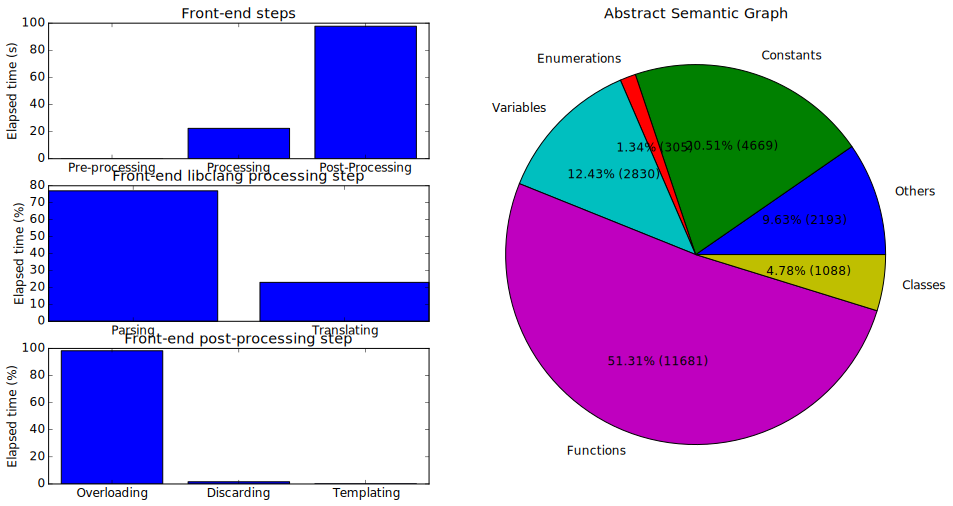

In [6]:
from vplants.autowig.front_end import front_end
front_end.plugin = 'libclang'
front_end(asg, headers, flags=flags, libpath='/usr/local/lib/libclang.so',
          silent=True, force_overload=False)

#### Middle end

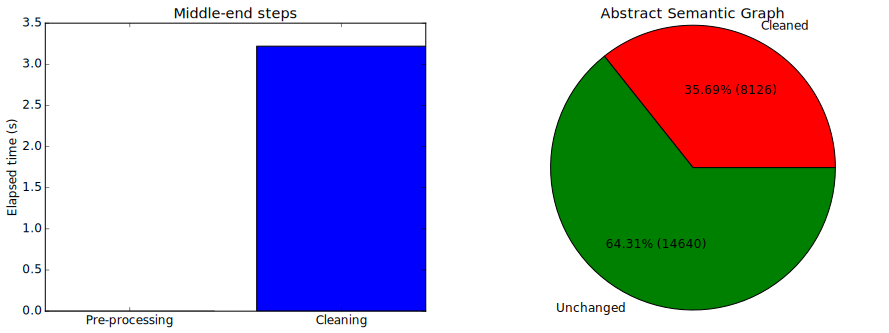

In [8]:
from vplants.autowig.middle_end import middle_end
from pyclanglite.bootstrap import BootstrapMiddleEndPlugin
middle_end['bootstrap:middle_end'] = BootstrapMiddleEndPlugin
middle_end.plugin = 'bootstrap:middle_end'
middle_end(asg)

#### Back end

In [11]:
from vplants.autowig.back_end import back_end
from pyclanglite.bootstrap import BootstrapBackEndPlugin
back_end['bootstrap:back_end'] = BootstrapBackEndPlugin
back_end.plugin = 'bootstrap:back_end'
back_end(asg, '../../pyclanglite/src/generatorer/pyclanglite.cpp',
         target='../../pyclanglite/src/pyclanglite', libclang=True)

Total files generated in memory,143 (f)
Total source lines of code,11129 (l)
Elapsed time,100.9 (s)
Development effort estimate,44.58 (p.m)
Schedule estimate,9.44 (m)
Estimated average number of developers,4.72 (p)


In [13]:
back_end.plugin = 'boost_python:on_disk'
back_end(asg)

Total files generated on disk,149 (f)
Total source lines of code,11661 (l)
Elapsed time,92.41 (s)
Development effort estimate,46.97 (p.m)
Schedule estimate,9.62 (m)
Estimated average number of developers,4.88 (p)


#### SCons integration

In [14]:
from vplants.autowig.scons import *
asg.add_sconstruct('../../pyclanglite')
asg.scons('-j', '3')

#### Test

In [16]:
%autoreload
%reload_ext vplants.autowig.rich_display
%reload_ext pyclanglite.rich_display

flags = ['-x', 'c++', '-g', '-std=c++11',
         '-I/usr/include',
         '-I' + includedir,
         '-I/usr/local/lib/clang/3.7.0/include',
         '-D__STDC_LIMIT_MACROS', '-D__STDC_CONSTANT_MACROS']

asg = AbstractSemanticGraph()

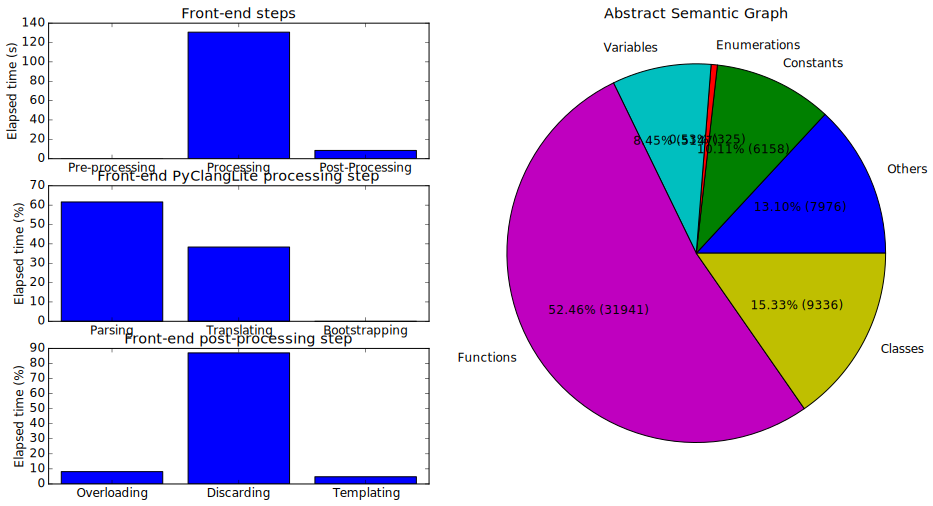

In [17]:
from pyclanglite_plugin.autowig import PyClangLiteFrontEndPlugin
front_end['pyclanglite'] = PyClangLiteFrontEndPlugin
front_end.plugin = 'pyclanglite'
front_end(asg, headers, flags=flags, silent=True, force_overload=True)

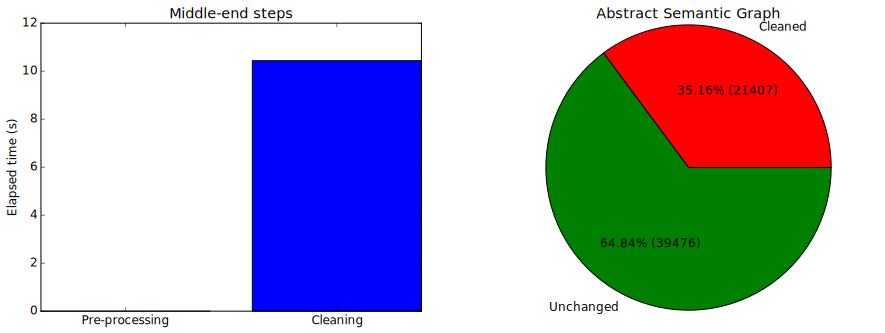

In [18]:
middle_end.plugin = 'bootstrap:middle_end'
middle_end(asg, libclang=False)

In [19]:
back_end.plugin = 'bootstrap:back_end'
back_end(asg, '../../pyclanglite/src/generatorer/pyclanglite.cpp',
         target='../../pyclanglite/src/pyclanglite', libclang=False)

Total files generated in memory,143 (f)
Total source lines of code,4464 (l)
Elapsed time,264.43 (s)
Development effort estimate,16.03 (p.m)
Schedule estimate,6.6 (m)
Estimated average number of developers,2.43 (p)


In [20]:
back_end.plugin = 'boost_python:on_disk'
back_end(asg)

Total files generated on disk,149 (f)
Total source lines of code,4996 (l)
Elapsed time,242.56 (s)
Development effort estimate,18.18 (p.m)
Schedule estimate,6.9 (m)
Estimated average number of developers,2.64 (p)


In [21]:
asg.add_sconstruct('../../pyclanglite')
asg.scons('-j', '3')